In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Import data prepared in previous steps (only data for 2018 survey, full time employment, and removed outliers) and used for all machine learning models. The target is hourly rate and predictors are economic sector (nace), company size (esize_class), gender, age class, profession (lpk), education. All these are categorical variables. Single numerical variable is experience in years.

In [2]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv') 
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


One fifth of records is kept for testing of models.

In [3]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:', 'train', len(y_train), ', test', len(y_test))

Dataset lengths: train 26114 , test 6529


# Model and predictions

## Voting regressor

Voting regressor pipline with model optimal individual model hyperparameters. Numerical feature is scaled with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and categorical features are encoded using [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) with automatically determined categories.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import NuSVR
from xgboost import XGBRegressor

numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("ordinal", OrdinalEncoder())])

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']),
        ("numerical", numeric_preprocessor, ['experience'])
    ],
    sparse_threshold=0
)

voting = VotingRegressor(estimators=[('gbr', HistGradientBoostingRegressor(learning_rate=0.15, max_depth=11, max_iter=300)),
                                     ('xgb', XGBRegressor(alpha=0.75, colsample_bytree=0.65, eta=0.3625, gamma=3.0, 
                                                        learning_rate=0.05, max_depth=12, min_child_weight=4, subsample=1.0)),
                                     ('rf', RandomForestRegressor(ccp_alpha=1e-06, max_depth=14, min_samples_leaf=8,
                                                        min_samples_split=4, n_estimators=650)),
                                     ('lm', LinearRegression()),
                                     ('svm', NuSVR(C=10.0, cache_size=5000, gamma=0.1))
                                     ])


model = Pipeline([('prep', preprocessor), 
                ('regr', voting)])


In [19]:
               
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 VotingRegressor(estimators=[('gbr',
                                              HistGradientBoostingRegressor...
                                                           max_delta_step=None,
                                                           max_depth=12,
                                                           max_leaves=None,
                                                           min_child_weight=4,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           n_estimators=100,
                                                           n_jobs=None,
                                                           num_parallel_tree=None, ...)),
                                             ('rf',
                                              RandomForestRegressor(ccp_alpha=1e-06,
                                                                    max_depth=14,
                                                                    min_samples_leaf=8,
                                                                    min_samples_split=4,
                                                                    n_estimators=650)),
                                             ('lm', LinearRegression()),
                                             ('svm',
                                              NuSVR(C=10.0, cache_size=5000,
                                                    gamma=0.1))]))])

Function to print model prediction RMSE and R2

In [20]:
def print_model_rmse_r2(model, X_train, y_train, X_test, y_test):
    """ 
    Function to print model prediction RMSE and R2
    for train and test datasets
        Parameters:
        model - model to evaluate
        X_train - train features
        y_train - train target 
        X_test - test features
        y_test - test target
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)

    r2_train = r2_score(y_train, y_train_pred).round(3)
    r2_test = r2_score(y_test, y_test_pred).round(3)

    print('Train: RMSE=', rmse_train, ' R2=', r2_train,
        '\nTest: RMSE=', rmse_test, ' R2=', r2_test)

RMSE and R2 of initial model predicions for train and test datasets.

In [21]:
print_model_rmse_r2(model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.494  R2= 0.655 
Test: RMSE= 1.623  R2= 0.592


## Feature importance 

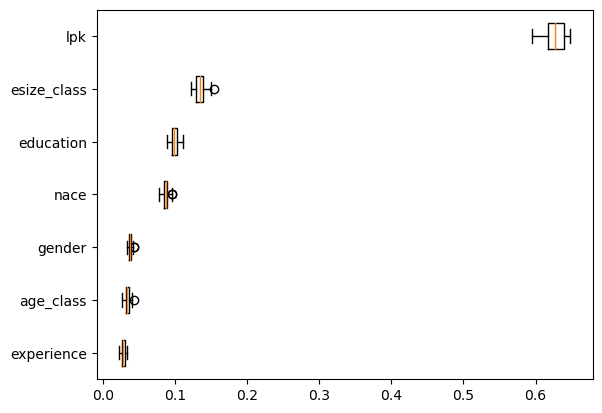

In [23]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test,  n_repeats=50,  random_state=0)
importance_order = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
plt.boxplot(
    perm_importance.importances[importance_order].T,
    vert=False,
    labels=np.array(X_test.columns)[importance_order],
);

By far the most important feature is profession (lpk) followed by company size and education. The economic sector, gender, age and experience are less important.

# Model (Pipline) Serialization 

In [24]:
import joblib
joblib.dump(model, './Models/SklearnVoting_model.joblib')

['./Models/SklearnVoting_model.joblib']